In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
import pandas as pd
import torch
import pickle
import config
import time
import IPython.display as IPd

from forward import Forward 
from survey import Survey
from util import *

# SBI imports
from sbi.inference import SNPE, SNLE, prepare_for_sbi, simulate_for_sbi, likelihood_estimator_based_potential, MCMCPosterior
from sbi import utils as utils
from sbi.utils import RestrictionEstimator
from sbi.utils import user_input_checks as uic
from sbi import analysis as analysis
from sbi.analysis import check_sbc, run_sbc, get_nltp, sbc_rank_plot


from torch.distributions import Distribution, Uniform, Normal
from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm, ListedColormap


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from svgutils.compose import *

_ = torch.manual_seed(0)

2024-07-28 14:25:12.789000: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-28 14:25:12.827258: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-28 14:25:12.827288: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-28 14:25:12.827311: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-28 14:25:12.835602: I tensorflow/core/platform/cpu_feature_g

### Setup Section

In [2]:
max_depth= 23.5
step_size= 0.5
num_points= int(max_depth/step_size) +1 
max_resistivity = 1000
min_resistivity = 1
num_measurements = 23
num_dim = 48

depths = np.linspace(0, max_depth, num=num_dim)
thicknesses = torch.ones(num_dim) * 0.5

In [3]:
# Survey Setup and Forward Model Setup

survey, electrode_spacing = Survey(num_measurements, min_ab_distance=2, max_ab_distance=100).schlumberger_survey()
forward = Forward(thicknesses, survey)
#pygimli = PyGimliInversion(num_measurements, electrode_spacing)

### Step Model and Functions

In [4]:
# Helper functions for the Step Model 

def steps_forward_model_no_noise(res):
     ''' Noiseless forward simulator for the step prior '''  
    return forward.dc_forward_model(res)

def steps_forward_model_base_noise_5(res):
    ''' Forward simulator for the step prior adding white noise (of magnitude 5 \Omega m) to the simulations '''
    if (np.any([res < 0])):
        nan_array = np.empty((num_measurements,))
        nan_array[:] = np.nan
        return nan_array
    return forward.dc_forward_model_base_noise(res, 5)


# Prior Setup
prior_min = torch.as_tensor([min_resistivity] * num_dim)
prior_max = torch.as_tensor([max_resistivity] * num_dim)
prior_ind_step = utils.BoxUniform(low=prior_min * torch.ones(num_dim), high=prior_max * torch.ones(num_dim))  

In [5]:
def compute_cis_and_means_from_step_posterior_sammples(observation):
     """
    Computes confidence intervals and means from step posterior samples posterior predictive samples based a given observation.
    The conditional density estimator is conditioned on the observation to obtain the posterior distribution. 
    100,000 samples are sampled and 1,000 random samples are evaluated under the forward simulator. 
    These are used to compute the mean and conf. intervals in observation and parameter space.


    Returns:
        - random_post_samples (Tensor): A subset of the posterior samples.
        - sim_apparent_resistivities (list): Simulated apparent resistivities from the posterior samples.
        - mean_res (ndarray): The mean of the posterior samples for the resistivity depth profile.
        - conf_intervals_res (ndarray): The confidence intervals for the resistivity depth profile.
        - mean_ar (ndarray): The mean of the simulated apparent resistivities.
        - conf_intervals_ar (ndarray): The confidence intervals for the simulated apparent resistivities.
    """
    
    posterior_sample_size = 100_000
    simulation_sample_size = 1_000
    percentiles = config.percentiles

    # Sample from Step posterior
    posterior_samples_step = posterior_ind_step.sample((posterior_sample_size,), x=observation, show_progress_bars=True)

    # Get random samples form the posterior samples
    perm = torch.randperm(posterior_sample_size)
    idx = perm[:simulation_sample_size]
    random_post_samples = posterior_samples_step[idx]

    # Simulate the Apparent Resistivity from the samples
    sim_apparent_resistivities=[]
    for sample in random_post_samples:
        app_res = steps_forward_model_base_noise_5(np.array(sample))
        sim_apparent_resistivities.append(app_res)


    # Compute confidence intervals and mean for resistivity depth profile
    conf_intervals_res = np.nanpercentile(random_post_samples, q=percentiles, axis=0)
    mean_res = np.nanmean(random_post_samples, axis=0)
    
    # Compute confidence intervals and mean in observation space
    conf_intervals_ar = np.nanpercentile(sim_apparent_resistivities, q=percentiles, axis=0)
    mean_ar = np.nanmean(sim_apparent_resistivities, axis=0)

    return random_post_samples, sim_apparent_resistivities, mean_res, conf_intervals_res, mean_ar, conf_intervals_ar

#### Train or Load Step Posterior

In [6]:
train_model = False
filename_ind_steps = "pickled_objects/ind_steps_500k_1000_ohm_48points.pkl"
num_simulations = 500_000


if train_model:

    # Prepare forward model and prior for SBI Inference (forward model 5 dimensional no noise added)
    simulator, prior_ind_step = prepare_for_sbi(steps_forward_model_base_noise_5, prior_ind_step)
    inference_ind_step = SNPE(prior=prior_ind_step, device="cpu", show_progress_bars=True)

    remaining_simulations = num_simulations
    while remaining_simulations > 0:    
        theta, x = simulate_for_sbi(simulator, prior_ind_step, remaining_simulations)
        valid_simulations = torch.all(~torch.isnan(x), dim=1)
        if any(valid_simulations):
            inference_ind_step.append_simulations(theta[valid_simulations], x[valid_simulations] )  # Gather the new and valid simulations in the `restriction_estimator`.
            remaining_simulations -= torch.sum(valid_simulations).item()
        else: 
            continue

    
    #(all_theta, all_x, _, ) = inference_step.get_simulations()
    density_estimator = inference_ind_step.train()

    posterior_ind_step = inference_ind_step.build_posterior(density_estimator)

    pickle_objects([inference_ind_step, posterior_ind_step], filename_ind_steps)
else:
    inference_ind_step, posterior_ind_step = unpickle_objects(filename_ind_steps)

## Expected Coverage

In [7]:
simulator, prior = prepare_for_sbi(steps_forward_model_base_noise_5, prior_ind_step)

In [9]:
thetas = prior.sample((1_000,))
xs = simulator(thetas)

ranks, dap_samples = run_sbc(thetas, xs, posterior_ind_step, num_posterior_samples=500)

(fig, ax) = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=500,
    plot_type="cdf",
    num_workers=30,
    num_bins=None,
)

Running 1000 sbc samples.:   0%|          | 0/1000 [00:00<?, ?it/s]

                    accepted. It may take a long time to collect the remaining
                    416 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
                    accepted. It may take a long time to collect the remaining
                    426 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
                    accepted. It may take a long time to collect the remaining
                    405 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
                    accepted. It may take a long time to collect the remaining
                    442 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
                    accepted. It may take a long time to collect the remaining
                    404 s

TypeError: sbc_rank_plot() got an unexpected keyword argument 'num_workers'

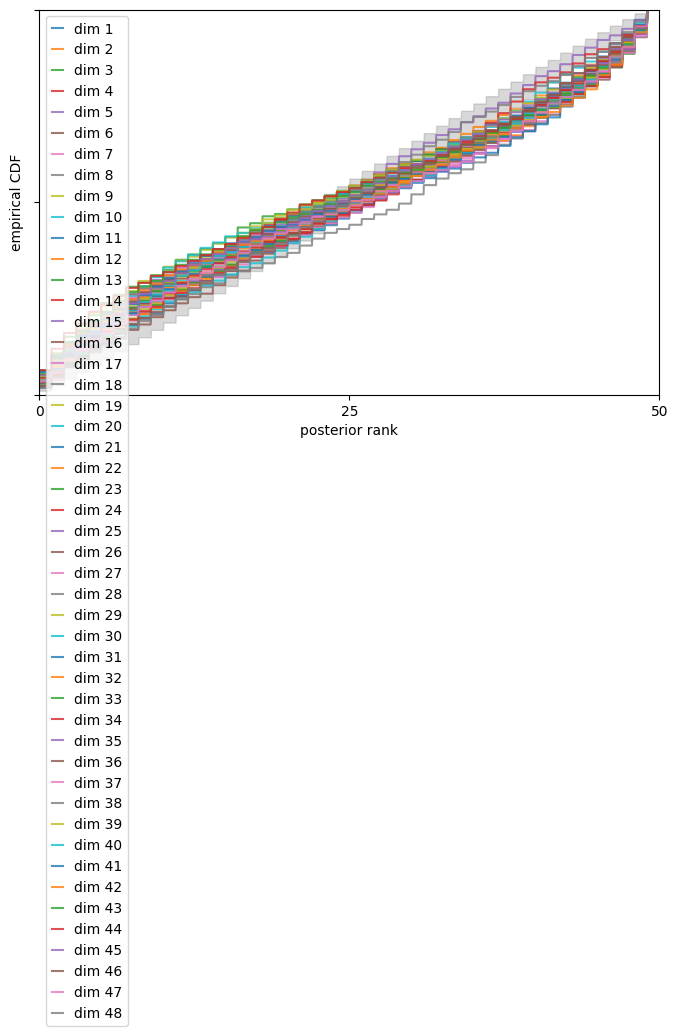

In [10]:
(fig, ax) = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=500,
    plot_type="cdf",
    num_bins=None,
)

In [38]:
colors=['#AB0000', '#BC0000', '#CF0000', '#E40000', '#DE100F', '#D81F1E', '#D81F1E', '#D52726', '#D52726', '#D22E2D', '#CF3635', '#CC3D3C']

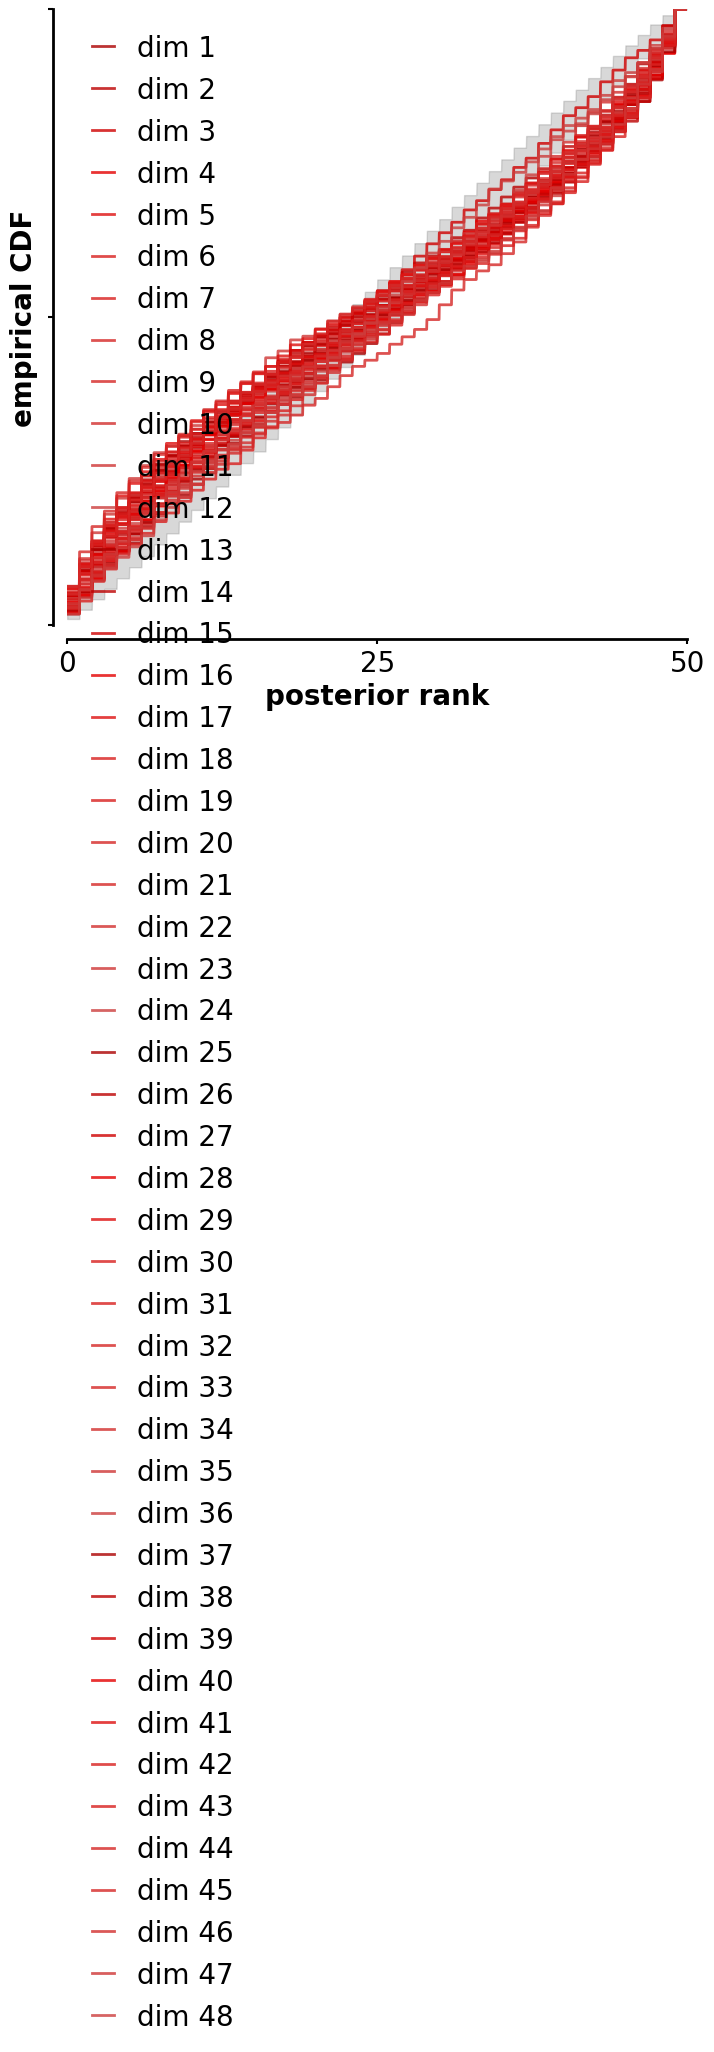

In [40]:
with mpl.rc_context(fname="plots/pltstyle.rc"):
    (fig, ax) = sbc_rank_plot(
        figsize=(8,8),
        ranks=ranks,
        num_posterior_samples=500,
        plot_type="cdf",
        num_bins=None,
        colors=colors*4
    )
    
    ax = fig.get_axes()
    
    # Hide the top and right spines
    ax[0].spines['top'].set_color('none')
    ax[0].spines['right'].set_color('none')
    
    # Optionally, adjust the ticks
    ax[0].xaxis.set_ticks_position('bottom')
    ax[0].yaxis.set_ticks_position('left')

    ax[0].spines['bottom'].set_position(('outward', 10)) 
    ax[0].spines['left'].set_position(('outward', 10)) 
    
    
    fig.savefig('plots/calibration/sbcc/ind_step_cdf_all.svg')


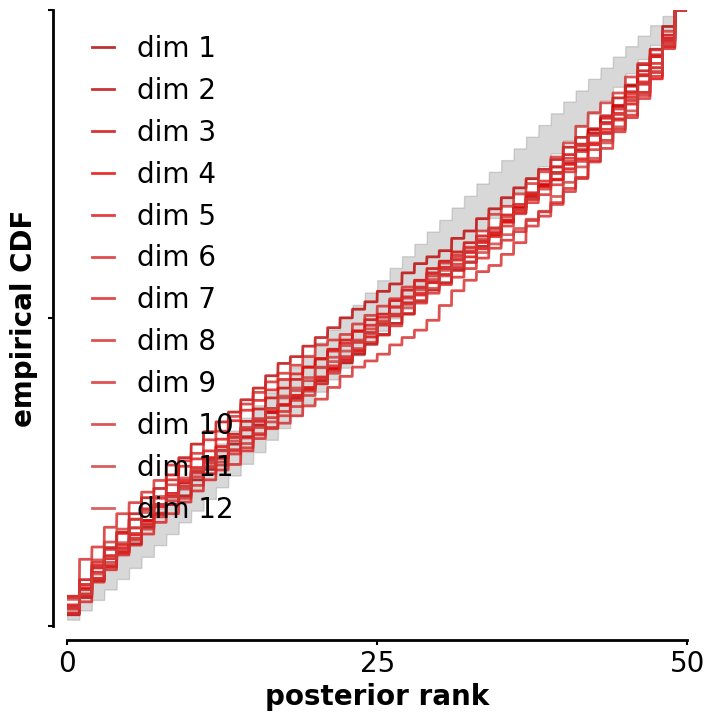

In [41]:
with mpl.rc_context(fname="plots/pltstyle.rc"):
    (fig, ax) = sbc_rank_plot(
        figsize=(8,8),
        ranks=ranks[:,:12],
        num_posterior_samples=500,
        plot_type="cdf",
        num_bins=None,
        colors=['#AB0000', '#BC0000', '#CF0000', '#E40000', '#DE100F', '#D81F1E', '#D81F1E', '#D52726', '#D52726', '#D22E2D', '#CF3635', '#CC3D3C']
    )
    
    ax = fig.get_axes()
    
    # Hide the top and right spines
    ax[0].spines['top'].set_color('none')
    ax[0].spines['right'].set_color('none')
    
    # Optionally, adjust the ticks
    ax[0].xaxis.set_ticks_position('bottom')
    ax[0].yaxis.set_ticks_position('left')

    ax[0].spines['bottom'].set_position(('outward', 10)) 
    ax[0].spines['left'].set_position(('outward', 10)) 
    
    
    fig.savefig('plots/calibration/sbcc/ind_step_cdf_0_12.svg')


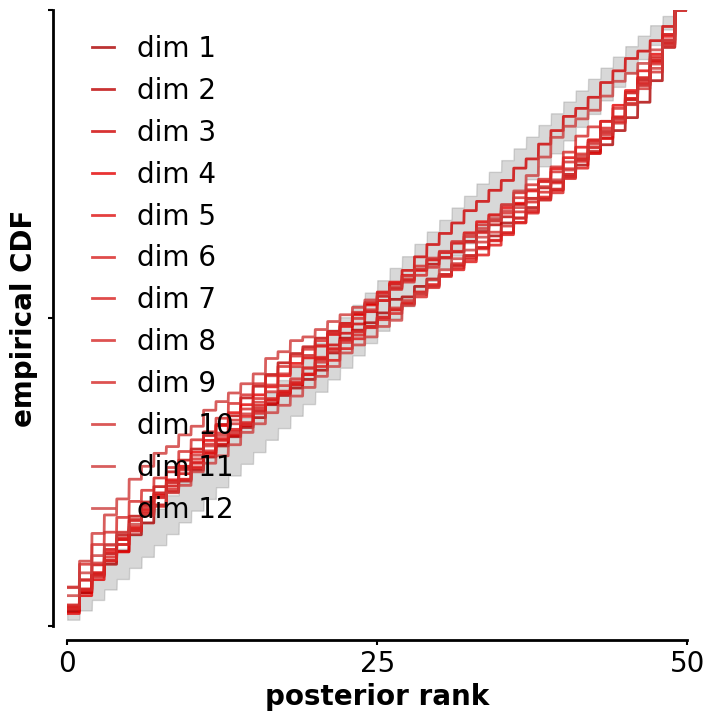

In [45]:
with mpl.rc_context(fname="plots/pltstyle.rc"):
    (fig, ax) = sbc_rank_plot(
        figsize=(8,8),
        ranks=ranks[:,12:24],
        num_posterior_samples=500,
        plot_type="cdf",
        num_bins=None,
        colors=colors
    )
    
    ax = fig.get_axes()
    
    # Hide the top and right spines
    ax[0].spines['top'].set_color('none')
    ax[0].spines['right'].set_color('none')
    
    # Optionally, adjust the ticks
    ax[0].xaxis.set_ticks_position('bottom')
    ax[0].yaxis.set_ticks_position('left')

    ax[0].spines['bottom'].set_position(('outward', 10)) 
    ax[0].spines['left'].set_position(('outward', 10)) 
    
    
    fig.savefig('plots/calibration/sbcc/ind_step_cdf_12_24.svg')


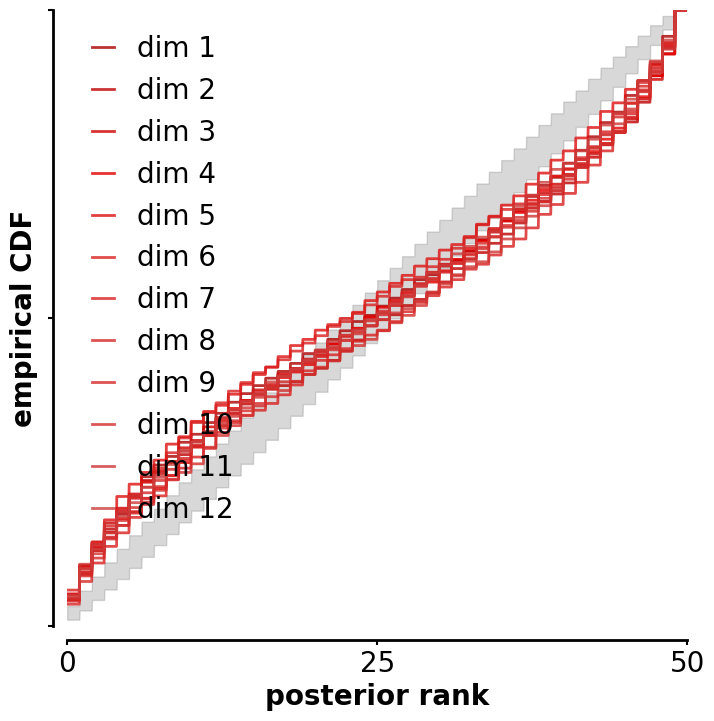

In [46]:
with mpl.rc_context(fname="plots/pltstyle.rc"):
    (fig, ax) = sbc_rank_plot(
        figsize=(8,8),
        ranks=ranks[:,24:36],
        num_posterior_samples=500,
        plot_type="cdf",
        num_bins=None,
        colors=colors
    )
    
    ax = fig.get_axes()
    
    # Hide the top and right spines
    ax[0].spines['top'].set_color('none')
    ax[0].spines['right'].set_color('none')
    
    # Optionally, adjust the ticks
    ax[0].xaxis.set_ticks_position('bottom')
    ax[0].yaxis.set_ticks_position('left')

    ax[0].spines['bottom'].set_position(('outward', 10)) 
    ax[0].spines['left'].set_position(('outward', 10)) 
    
    
    fig.savefig('plots/calibration/sbcc/ind_step_cdf_24_36.svg')


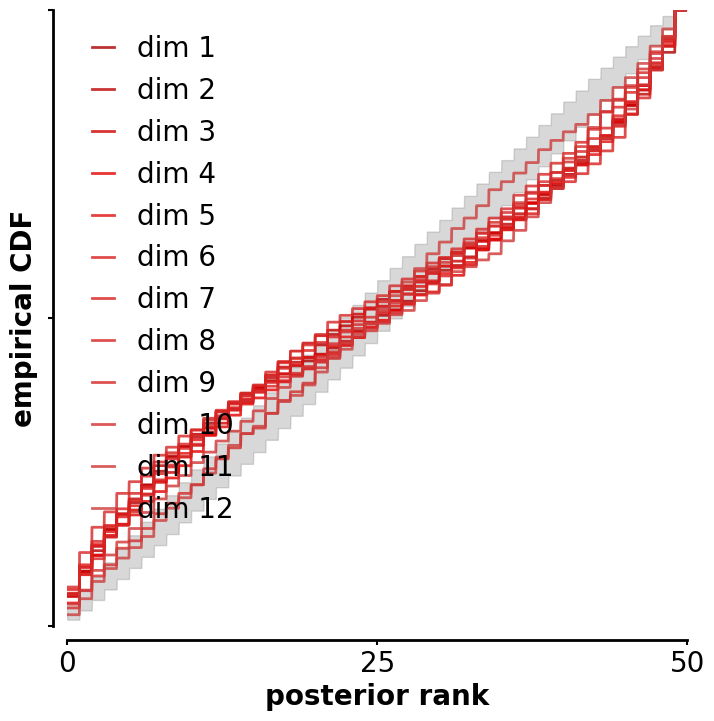

In [47]:
with mpl.rc_context(fname="plots/pltstyle.rc"):
    (fig, ax) = sbc_rank_plot(
        figsize=(8,8),
        ranks=ranks[:,36:],
        num_posterior_samples=500,
        plot_type="cdf",
        num_bins=None,
        colors=colors
    )
    
    ax = fig.get_axes()
    
    # Hide the top and right spines
    ax[0].spines['top'].set_color('none')
    ax[0].spines['right'].set_color('none')
    
    # Optionally, adjust the ticks
    ax[0].xaxis.set_ticks_position('bottom')
    ax[0].yaxis.set_ticks_position('left')

    ax[0].spines['bottom'].set_position(('outward', 10)) 
    ax[0].spines['left'].set_position(('outward', 10)) 
    
    
    fig.savefig('plots/calibration/sbcc/ind_step_cdf_36_48.svg')
